# Final Project Problem 1

In this problem, we are prompted (pun intended) to use an LLM to attempt to answer some questions from previous homeworks. I use the ChatGPT-4o model here, since it has a large number of free tokens per day. To mirror what a typical undergraduate or early-grad student might use, I interface with the model through the openAI web app, rather than through the API with a custom script. In my own research, I use Anthropic's Claude 3.7 Sonnet model through the Zed text editor with a set of custom prompts.

For each problem, I start with a fresh conversation. I start by inputting the entire problem setup, directly copy-pasted from the assignment, including any necessary background information from the documents. I then test the code from each model. If the code is unsuccessful, I then prompt the model further. At first, I simply tell it what error occurred without any advice. If this still fails to provide a correct solution, I then analyze the generated code and find any conceptual misunderstandings, and convey these findings to the LLM. Finally, if after a few iterations of this process the model is still unable to output workable code, then I move on.

## Chat GPT Solution for HW1, problem 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
G = 4.302e-6  # (kpc * km^2) / (s^2 * Msun)
M = 1e12      # Total mass in Msun
a = 35.0      # Scale radius in kpc
N = int(10)  # Number of particles (use 1e6 for full sim, smaller for tests)

phi0 = -G * M / a  # Characteristic potential for normalization

# Dimensionless f(Q) from Hernquist 1990 (Eq. 17)
def fQ(Q):
    f = np.zeros_like(Q)
    mask = (Q > 0) & (Q < 1)
    q = Q[mask]
    
    term1 = (1 - 2*q)**(1.5) * (1 - 6*q + 6*q**2)
    term1[q >= 0.5] = 0  # Avoid invalid sqrt at high Q

    term2 = 60 * q**3 * np.sqrt(1 - q) * np.arcsin(np.sqrt(q))
    f[mask] = (term1 + term2) / (q**(2.5))
    return f

# Sample Q ∈ [0, Ψ] using rejection sampling
def sample_Q(Psi, Q_grid, fQ_interp):
    Q_samples = np.zeros_like(Psi)
    for i, psi in enumerate(Psi):
        accepted = False
        while not accepted:
            q_trial = np.random.uniform(0, psi)
            f_trial = fQ_interp(q_trial)
            f_max = fQ_interp(psi) * psi
            if np.random.rand() < (f_trial * (psi - q_trial)) / (f_max + 1e-10):
                Q_samples[i] = q_trial
                accepted = True
    return Q_samples

from scipy.interpolate import interp1d

def sample_Q_bounded(Psi, fQ_interp, N_samples):
    Q_samples = np.zeros(N_samples)
    for i in range(N_samples):
        psi = Psi[i]
        accepted = False
        while not accepted:
            q_trial = np.random.beta(1.5, 1.5) * psi  # rescale to [0, Psi]
            f_val = fQ_interp(q_trial)
            target_pdf = f_val * (psi - q_trial)
            bounding_pdf = np.sqrt(q_trial * (1 - q_trial / psi))  # scaled beta
            A = 5  # empirically determined upper bound factor
            if np.random.rand() < target_pdf / (A * bounding_pdf + 1e-10):
                Q_samples[i] = q_trial
                accepted = True
    return Q_samples

def sample_Q_adaptive(Psi_array, fQ_interp, N_samples):
    Q_samples = np.zeros(N_samples)
    A = 2.0  # fixed safe bound, can be tuned
    for i in range(N_samples):
        psi = Psi_array[i]
        accepted = False
        attempts = 0
        while not accepted:
            u = np.random.beta(1.5, 1.5)
            q = u * psi
            f_val = fQ_interp(q)
            target = f_val * (1 - u)
            bound = A * np.sqrt(u * (1 - u))
            if np.random.rand() < target / (bound + 1e-12):
                Q_samples[i] = q
                accepted = True
            attempts += 1
            if attempts > 1000:
                raise RuntimeError(f"Too many rejections for Ψ={psi:.3f}")
    return Q_samples


def build_bounding_function():
    Q_grid = np.linspace(1e-4, 0.9999, 1000)
    f_vals = fQ(Q_grid)
    g_vals = np.sqrt(Q_grid * (1 - Q_grid))  # shape of Beta(1.5, 1.5)
    ratio = f_vals * (1 - Q_grid) / g_vals
    A = np.max(ratio) * 1.1  # add 10% safety buffer
    return interp1d(Q_grid, f_vals, bounds_error=False, fill_value=0), A

def sample_Q_bounded_fixed(Psi_array, fQ_interp, A, N_samples):
    Q_samples = np.zeros(N_samples)
    for i in range(N_samples):
        psi = Psi_array[i]
        accepted = False
        attempts = 0
        while not accepted:
            q_unit = np.random.beta(1.5, 1.5)  # in [0,1]
            q = q_unit * psi  # scale to [0, Psi]
            f_val = fQ_interp(q)
            target = f_val * (psi - q)
            bound = A * np.sqrt(q / psi * (1 - q / psi))
            u = np.random.rand()
            if u < target / (bound + 1e-12):
                Q_samples[i] = q
                accepted = True
            attempts += 1
            if attempts > 1000:
                raise RuntimeError(f"Too many rejections for Ψ={psi:.3f}")
    return Q_samples



# Sample radii from Hernquist profile using inverse CDF
def sample_radius(N):
    x = np.random.uniform(0, 1, N)
    return a * np.sqrt(x) / (1 - np.sqrt(x))

# Sample isotropic velocities given magnitude
def velocity_components(v_mag):
    theta = np.arccos(2 * np.random.rand(len(v_mag)) - 1)
    phi = 2 * np.pi * np.random.rand(len(v_mag))
    vx = v_mag * np.sin(theta) * np.cos(phi)
    vy = v_mag * np.sin(theta) * np.sin(phi)
    vz = v_mag * np.cos(theta)
    return vx, vy, vz

# Position sampling
r = sample_radius(N)
phi_r = -G * M / (r + a)
Psi = phi_r / phi0  # Normalized potential

assert np.all(Psi > 0) and np.all(Psi < 1), "Psi values must be in (0,1)"

# Precompute f(Q) interpolation on grid
from scipy.interpolate import interp1d
Q_grid = np.linspace(1e-5, 0.999, 1000)
fQ_grid = fQ(Q_grid)
fQ_interp = interp1d(Q_grid, fQ_grid, bounds_error=False, fill_value=0.0)

# Sample Q and convert to v
fQ_interp, A_bound = build_bounding_function()
Q_samples = sample_Q_bounded_fixed(Psi, fQ_interp, A_bound, N)


v_mag = np.sqrt(2 * (phi_r + Q_samples * phi0))
vx, vy, vz = velocity_components(v_mag)

# Sample 3D positions
theta_pos = np.arccos(2 * np.random.rand(N) - 1)
phi_pos = 2 * np.pi * np.random.rand(N)
x = r * np.sin(theta_pos) * np.cos(phi_pos)
y = r * np.sin(theta_pos) * np.sin(phi_pos)
z = r * np.cos(theta_pos)

# Radial velocity component
vr = (x * vx + y * vy + z * vz) / r

# --- Diagnostics: Velocity dispersion profile ---
bin_edges = np.logspace(np.log10(np.min(r)), np.log10(np.max(r)), 40)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
vr_disp = np.zeros_like(bin_centers)

for i in range(len(bin_centers)):
    in_bin = (r >= bin_edges[i]) & (r < bin_edges[i+1])
    if np.sum(in_bin) > 10:
        vr_disp[i] = np.sqrt(np.mean(vr[in_bin]**2))

# Plot
plt.figure(figsize=(8, 5))
plt.loglog(bin_centers, vr_disp, label=r'$\sigma_r$ (simulated)')
plt.xlabel('r [kpc]')
plt.ylabel(r'Radial Velocity Dispersion $\sigma_r$ [km/s]')
plt.title('Radial Velocity Dispersion Profile')
plt.grid(True, which="both", ls='--')
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/py/d6rmhh8d221_729lchpqs_mw0000gq/T/ipykernel_41628/2895854970.py:18: RuntimeWarning: invalid value encountered in power
  term1 = (1 - 2*q)**(1.5) * (1 - 6*q + 6*q**2)


RuntimeError: Too many rejections for Ψ=0.207

In this case, despite significant prompting, I was unable to get the model to output successful code. The issue is that the model seems to have not properly defined an analytic bounding function that is sufficiently low at the low energy scales. As a result, the sampling of those scales is indefinitely stuck. After explicitly telling this to the LLM, it was still unable to produce workable code after several iterations. The verdict is that, at least for this model with this approach, this LLM would not be successfully be able to replace a student.

## Chat GPT Solution for HW2, problem 1

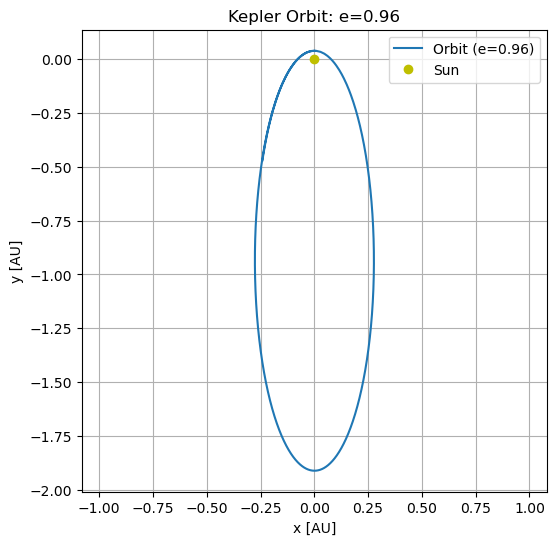

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants in AU^3 / yr^2 / solar mass
G = 4 * np.pi**2
M = 1.0          # Mass of the Sun in solar masses
a = 1.0          # Semi-major axis in AU
e = 0.96         # Eccentricity
T = 1.0          # Orbital period in years (for a = 1 AU)

# Pericenter and velocity at pericenter
rp = a * (1 - e)
vp = np.sqrt(G * M / a * (1 + e) / (1 - e))

# Initial state: position and velocity vectors
r0 = np.array([0.0, rp])
v0 = np.array([-vp, 0.0])
y0 = np.concatenate((r0, v0))  # [x, y, vx, vy]

# Time settings
dt = 0.0005  # Step size in years (~0.18 days)
num_steps = int(T / dt)

# Derivative function
def derivatives(t, y):
    x, y_pos, vx, vy = y
    r = np.sqrt(x**2 + y_pos**2)
    ax = -G * M * x / r**3
    ay = -G * M * y_pos / r**3
    return np.array([vx, vy, ax, ay])

# Runge-Kutta 4th order integrator
def rk4_step(t, y, dt):
    k1 = derivatives(t, y)
    k2 = derivatives(t + dt/2, y + dt * k1 / 2)
    k3 = derivatives(t + dt/2, y + dt * k2 / 2)
    k4 = derivatives(t + dt, y + dt * k3)
    return y + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

# Integration loop
trajectory = np.zeros((num_steps, 4))
trajectory[0] = y0
time = np.zeros(num_steps)

for i in range(1, num_steps):
    trajectory[i] = rk4_step(time[i-1], trajectory[i-1], dt)
    time[i] = time[i-1] + dt

# Extract x and y
x_vals = trajectory[:, 0]
y_vals = trajectory[:, 1]

# Plot orbit
plt.figure(figsize=(6, 6))
plt.plot(x_vals, y_vals, label=f'Orbit (e={e})', lw=1.5)
plt.plot(0, 0, 'yo', label='Sun')  # Sun at origin
plt.axis('equal')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title(f'Kepler Orbit: e={e}')
plt.grid(True)
plt.legend()
plt.show()


On the first try, the LLM was able to generate an orbit that looks roughly correct (with just the problem description). However, looking closely, I think it wasn't quite right. To check this, I checked the integration for several values of dt and plotted the convergence. The convergence did not match the expected rate of O(n^4).

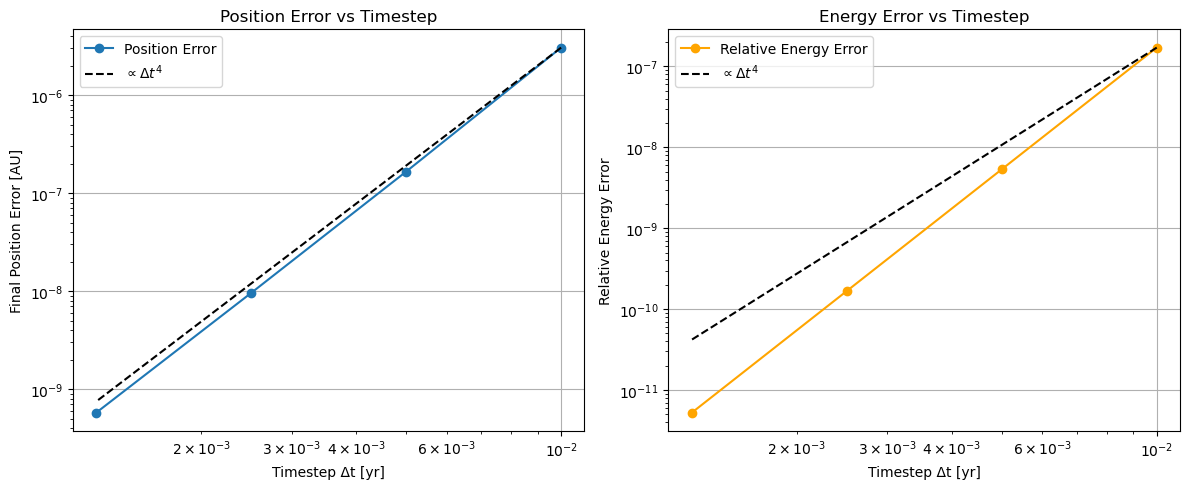

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
G = 4 * np.pi**2  # AU^3 / yr^2 / M_sun
M = 1.0           # Solar mass
a = 1.0           # Semi-major axis (AU)
e = 0.          # Eccentricity
T = 1.0           # Orbital period (yr)

# Initial conditions
rp = a * (1 - e)
vp = np.sqrt(G * M / a) * np.sqrt((1 + e) / (1 - e))
y0 = np.array([0.0, rp, -vp, 0.0])  # [x, y, vx, vy]

# --- RK4 Step ---
def rk4_step(t, y, dt):
    def f(y):
        r = y[:2]
        v = y[2:]
        r_norm = np.linalg.norm(r)
        a = -G * M * r / r_norm**3
        return np.array([v[0], v[1], a[0], a[1]])

    k1 = f(y)
    k2 = f(y + 0.5 * dt * k1)
    k3 = f(y + 0.5 * dt * k2)
    k4 = f(y + dt * k3)
    return y + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

# --- Total Energy ---
def total_energy(y):
    r = np.linalg.norm(y[:, :2], axis=1)
    v2 = np.sum(y[:, 2:]**2, axis=1)
    E = 0.5 * v2 - G * M / r
    return E

# --- Convergence Testing ---
dts = [0.01, 0.005, 0.0025, 0.00125]
position_errors = []
energy_errors = []

for dt in dts:
    num_steps = int(T / dt)
    t = 0.0
    y = np.zeros((num_steps + 2, 4))
    y[0] = y0

    for i in range(1, num_steps + 1):
        y[i] = rk4_step(t, y[i-1], dt)
        t += dt

    # Final fractional step to exactly hit T
    overshoot = t - T
    if overshoot > 0:
        t -= dt
        y_last = rk4_step(t, y[num_steps-1], T - t)
        y[num_steps + 1] = y_last
        final_index = num_steps + 1
    else:
        final_index = num_steps

    # Position error
    pos_err = np.linalg.norm(y[final_index, :2] - y0[:2])
    position_errors.append(pos_err)

    # Energy error
    E_initial = total_energy(y[[0]])[0]
    E_final = total_energy(y[[final_index]])[0]
    rel_energy_err = abs(E_final - E_initial) / abs(E_initial)
    energy_errors.append(rel_energy_err)

# --- Reference lines for Δt^4 ---
ref_dt = dts[0]
dt_vals = np.array(dts)
pos_ref_line = position_errors[0] * (dt_vals / ref_dt)**4
eng_ref_line = energy_errors[0] * (dt_vals / ref_dt)**4

# --- Plotting ---
plt.figure(figsize=(12, 5))

# --- Position error ---
plt.subplot(1, 2, 1)
plt.loglog(dts, position_errors, 'o-', label='Position Error')
plt.loglog(dts, pos_ref_line, 'k--', label=r'$\propto \Delta t^4$')
plt.xlabel('Timestep Δt [yr]')
plt.ylabel('Final Position Error [AU]')
plt.title('Position Error vs Timestep')
plt.grid(True)
plt.legend()

# --- Energy error ---
plt.subplot(1, 2, 2)
plt.loglog(dts, energy_errors, 'o-', color='orange', label='Relative Energy Error')
plt.loglog(dts, eng_ref_line, 'k--', label=r'$\propto \Delta t^4$')
plt.xlabel('Timestep Δt [yr]')
plt.ylabel('Relative Energy Error')
plt.title('Energy Error vs Timestep')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


I think the source of the problem was that the integration was taking an integer number of steps, which lead to the total integrated orbital time being slightly less than a year. This is essentially a truncation error, which made the convergence rate different than it would have been otherwise. Once I pointed this out to the LLM, it was able to amend the code and produce the expected output. The solution is organized slightly differently than my original one, but is conceptually very similar.

The LLM could replace a student to an extent, but got the best results from an informed student.

## Chat GPT Solution for Hogg & Foreman-Mackey, problem 2

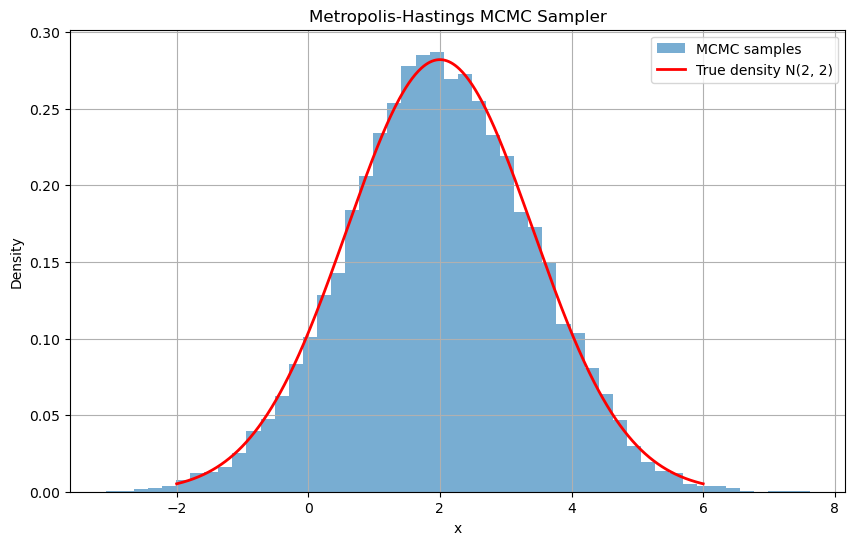

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Target distribution: N(2, 2)
def target_density(x):
    return norm.pdf(x, loc=2, scale=np.sqrt(2))

# Proposal: N(x, 1)
def metropolis_hastings(num_samples=10000):
    samples = []
    x = 0.0  # initial sample

    for _ in range(num_samples):
        x_proposal = np.random.normal(loc=x, scale=1.0)
        acceptance_ratio = target_density(x_proposal) / target_density(x)
        
        if np.random.rand() < acceptance_ratio:
            x = x_proposal  # accept
        # else: reject (x stays the same)

        samples.append(x)

    return np.array(samples)

# Run the sampler
samples = metropolis_hastings(20000)

# Plotting
x_vals = np.linspace(-2, 6, 500)
true_pdf = norm.pdf(x_vals, loc=2, scale=np.sqrt(2))

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, label='MCMC samples')
plt.plot(x_vals, true_pdf, 'r-', lw=2, label='True density N(2, 2)')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis-Hastings MCMC Sampler')
plt.legend()
plt.grid(True)
plt.show()


The LLM was able to correctly solve this problem on the first try. This makes sense, since this is an extremely common and fundamental problem. The solution makes use of more built-in functions than me (functions from scipy, numpy, etc.). This makes the code more efficient, whereas in class we intentionally didn't use these to get more pedagalogical value from the assignment. In this case, the LLM could replace the student :O